In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import psycopg
import credencials
import plotly.express as px

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [40]:
week = 'week'


In [5]:
# Connect to the sql server
conn = psycopg.connect(
        host="sculptor.stat.cmu.edu", dbname=credencials.DB_USER,
        user=credencials.DB_USER, password=credencials.DB_PASSWORD
)

cur = conn.cursor()

In [41]:
hospital_records = pd.read_sql_query("SELECT date, count(hospital_pk) from hospital_weekly where date <= %(week)s group by(date) order by date;", conn, params={'week':week})

/home/ruohaow/enter/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



In [42]:
print(hospital_records)

         date  count
0  2022-09-23   4995
1  2022-09-30   4997
2  2022-10-07   4996


<AxesSubplot:xlabel='date'>

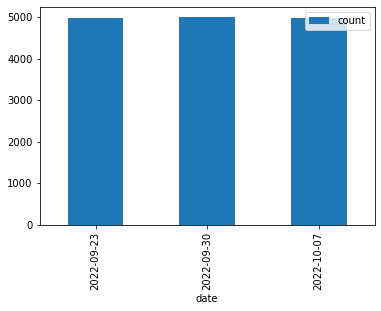

In [43]:
hospital_records.plot(kind='bar', x='date', y = 'count')

In [81]:
weekly_bed = pd.read_sql_query("select date,sum(coalesce(adult_bed_avail,0)) as Adult_Beds_Avail, sum(coalesce(child_bed_avail,0)) as Child_Beds_Avail, \
    sum(adult_bed_used) as Adult_Beds_Used,\
     sum(child_bed_used) as Child_Bed_Used, sum(all_COVID_patient) as All_COVID_Patient from hospital_weekly as a where date between (date (%(week2)s) - interval '4 week') and %(week1)s\
         group by a.date order by a.date limit 10; ", conn, params={'week1':week, 'week2':week})
print(weekly_bed)

         date  adult_beds_avail  child_beds_avail  adult_beds_used  \
0  2022-09-23          413559.5           39605.5          34825.0   
1  2022-09-30          416279.4           39804.7          34852.0   
2  2022-10-07          415465.4           39796.8          34886.0   

   child_bed_used  all_covid_patient  
0         27778.1            25600.6  
1         28042.8            24142.5  
2         28285.8            23689.3  


/home/ruohaow/enter/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



In [53]:
quality_need = pd.read_sql_query("select b.quality, sum(a.adult_bed_used) + sum(a.child_bed_used) as total_bed\
    from hospital_weekly as a inner join (select b.hospital_pk, b.quality from (select a.*, (rank() OVER (PARTITION BY\
        hospital_pk ORDER BY date desc)) as rank from hospital_quality as a where date <= %(week)s and quality is not null) as b where rank = 1) b\
            ON a.hospital_pk = b.hospital_pk and a.date = %(week)s group by b.quality order by b.quality;", conn, params={'week':week})
print(quality_need)

   quality  total_bed
0      1.0     2910.7
1      2.0     9203.3
2      3.0    10979.1
3      4.0    11338.1
4      5.0     4432.8


/home/ruohaow/enter/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



In [ ]:
quality_need = pd.read_sql_query("select b.quality, sum(a.adult_bed_used) + sum(a.child_bed_used) as total_bed\
    from hospital_weekly as a inner join (select b.hospital_pk, b.quality from (select a.*, (rank() OVER (PARTITION BY\
        hospital_pk ORDER BY date desc)) as rank from hospital_quality as a where date <= %(week)s and quality is not null) as b where rank = 1) b\
            ON a.hospital_pk = b.hospital_pk and a.date = %(week)s group by b.quality order by b.quality;", conn, params={'week':week})
print(quality_need)

In [55]:
hospital_beds = pd.read_sql_query("select date, sum(adult_bed_used) + sum(child_bed_used) as All, sum(all_COVID_patient) as COVID\
   from hospital_weekly where date <= %(week)s group by date order by date; \
           ;", conn, params={'week':week})
print(hospital_beds)

         date      all    covid
0  2022-09-23  62603.1  25600.6
1  2022-09-30  62894.8  24142.5
2  2022-10-07  63171.8  23689.3


/home/ruohaow/enter/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



(array([19258., 19260., 19262., 19264., 19266., 19268., 19270., 19272.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

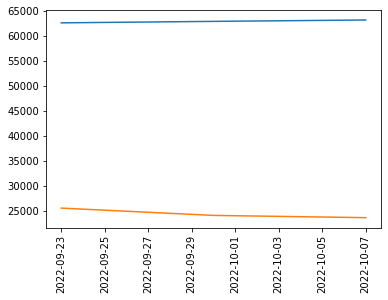

0    2022-09-23
1    2022-09-30
2    2022-10-07
Name: date, dtype: object


In [67]:
date = hospital_beds['date']
all = hospital_beds['all']
covid = hospital_beds['covid']
plt.plot(date, all)
plt.plot(date, covid)
plt.xticks(rotation = 90)
plt.show()
print(date)

In [68]:
covid_map = pd.read_sql_query("select state, sum(all_COVID_patient) as covid_sum from \
     hospital_weekly as a full outer join hospital as b on \
        a.hospital_pk = b.hospital_pk where date = %(week)s group by b.state; \
           ", conn, params={'week':week})
print(covid_map)

   state  covid_sum
0     CA     1789.5
1     NH      104.0
2     OR      303.2
3     TX     1349.8
4     ND       50.4
5     PR      130.7
6     NV      109.1
7     KY      309.7
8     OH      981.1
9     GU        NaN
10    NY     2811.4
11    HI       42.1
12    NM       59.0
13    MS       95.7
14    IN      257.3
15    DC      124.1
16    WV      165.3
17    NE      122.4
18    FL     1468.3
19    MO      612.0
20    ME      189.5
21    AR      163.7
22    WI      350.2
23    NC     1422.7
24    CT      423.1
25    SD       46.4
26    RI       82.8
27    OK      165.3
28    ID       82.6
29    GA      753.1
30    MN      423.1
31    PA     1602.2
32    MD      612.8
33    AK       16.7
34    WY        6.9
35    LA      100.3
36    MT       34.6
37    IL      850.2
38    TN      335.3
39    WA      424.0
40    NJ     1045.2
41    MI      976.5
42    MA      805.7
43    AL      230.3
44    UT       76.5
45    IA      115.2
46    VT       41.4
47    CO      165.8
48    SC      188.9


/home/ruohaow/enter/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



In [69]:
fig = px.choropleth(covid_map,
                    locations='state', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='covid_sum',
                    color_continuous_scale="Viridis_r", 
                    
                    )
fig.show()

In [77]:
covid_increase = pd.read_sql_query("select a.state, (a.covid_current - b.covid_prev) as COVID_Increase from (select state, sum(all_COVID_patient) as covid_current from \
     hospital_weekly as a full outer join hospital as b on \
        a.hospital_pk = b.hospital_pk where date = %(week)s group by b.state) a inner join (select state, sum(all_COVID_patient) as covid_prev from \
     hospital_weekly as a full outer join hospital as b on \
        a.hospital_pk = b.hospital_pk where date = date (%(week)s) - interval '1 week' group by b.state) b on a.state = b.state order by (a.covid_current - b.covid_prev) DESC\
         limit 10; \
           ", conn, params={'week':week})

print(covid_increase)

  state  covid_increase
0    GU             NaN
1    VI             NaN
2    NY           204.0
3    NJ           111.4
4    PA            89.3
5    MA            85.4
6    IL            37.5
7    WI            30.0
8    CO            17.5
9    NH            11.7


/home/ruohaow/enter/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



In [80]:
covid_most = pd.read_sql_query("select a.hospital_name, (a.covid_current - b.covid_prev) as COVID_Increase from (select b.hospital_name, a.hospital_pk, sum(all_COVID_patient) as covid_current from \
     hospital_weekly as a full outer join hospital as b on \
        a.hospital_pk = b.hospital_pk where date = %(week)s group by a.hospital_pk, b.hospital_name) a inner join (select b.hospital_name, a.hospital_pk, sum(all_COVID_patient) as covid_prev from \
     hospital_weekly as a full outer join hospital as b on \
        a.hospital_pk = b.hospital_pk where date = date (%(week)s) - interval '1 week' group by a.hospital_pk, b.hospital_name) b on a.hospital_pk = b.hospital_pk order by (a.covid_current - b.covid_prev) DESC\
         limit 10; \
           ", conn, params={'week':week})
print(covid_most)

                           hospital_name covid_increase
0                    DALE MEDICAL CENTER           None
1           NORTH ALABAMA MEDICAL CENTER           None
2  MARSHALL MEDICAL CENTERS SOUTH CAMPUS           None
3            CRENSHAW COMMUNITY HOSPITAL           None
4                      ST VINCENT'S EAST           None
5         DEKALB REGIONAL MEDICAL CENTER           None
6          SHELBY BAPTIST MEDICAL CENTER           None
7               MIZELL MEMORIAL HOSPITAL           None
8         HELEN KELLER MEMORIAL HOSPITAL           None
9           BAPTIST MEDICAL CENTER SOUTH           None


/home/ruohaow/enter/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy

